In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import astropy.units as u 
from astropy.coordinates import SkyCoord
import regions
from regions import Regions

from spectral_cube import SpectralCube
import importlib as imp

from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC


In [45]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [46]:
import moment_maker as mm
from jwst_plots import JWSTCatalog, make_cat_use
import cutout_manager as cm
import jwst_plots
import co_ice as co_map
imp.reload(jwst_plots)
import extinction as ex

In [47]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


## Catalog

In [5]:
cat_use = make_cat_use()

In [6]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

In [7]:
cutout_405 = cm.get_cutout_405(pos, w, l)
ww = cutout_405.wcs
data = cutout_405.data
blank_cutout = np.zeros_like(data)*np.nan

In [33]:
cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], ww))
mask_red = (cat_filament.color('f182m', 'f410m') > 2) | (np.isnan(np.array(cat_filament.band('f182m'))) & np.isnan(np.array(cat_filament.band('f187n'))))
mask_red = mask_red & (cat_filament.color('f410m', 'f466n') < 0)
cat_filament = JWSTCatalog(cat_filament.catalog[mask_red])

In [9]:
co_column_map = co_map.make_co_column_map()

  column,   mag410,  mag410*,  mag466n, mag466n*, dmag410, dmag466
   1e+15,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   2e+15,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   4e+15,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   7e+15,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   1e+16,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   3e+16,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   6e+16,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   1e+17,    -14.1,    -14.1,    -13.9,    -14.0,      0.0,      0.0
   2e+17,    -14.1,    -14.1,    -13.9,    -14.0,      0.0,      0.1
   4e+17,    -14.1,    -14.1,    -13.9,    -14.0,      0.0,      0.1
   8e+17,    -14.1,    -14.1,    -13.8,    -14.0,      0.0,      0.2
   2e+18,    -14.1,    -14.1,    -13.7,    -14.0,      0.0,      0.3
   3e+18,    -14.1,    -14.1,    -13.7,    -14.0,      0.0,      0.3
   6e+18,    -14.1,    -14.1,    -13

In [ ]:
mask_use = (cat_use.color('f182m', 'f410m') > 2) | (np.isnan(np.array(cat_use.band('f182m'))) & np.isnan(np.array(cat_use.band('f187n'))))
mask_use = mask_use & (cat_use.color('f410m', 'f466n') < 0)
cat_use_m = JWSTCatalog(cat_use.catalog[mask_use])

# Extinction

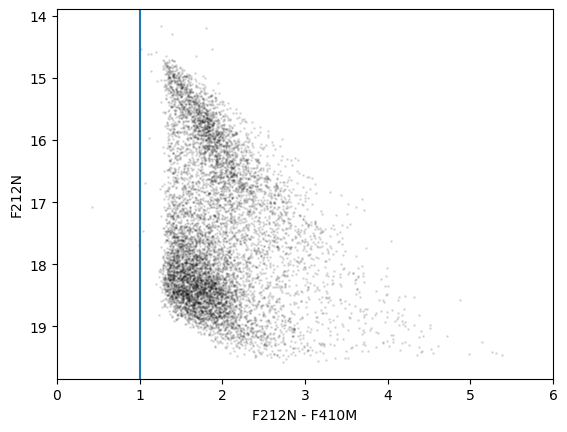

In [ ]:
ax = plt.subplot(111)
cat_filament.plot_CMD('f212n', 'f410m', 'f212n', color='k', s=1, alpha=0.1, ax=ax)
ax.set_xlim(0, 6)
ax.axvline(1)


Text(0, 0.5, 'A$_V$ 212/410')

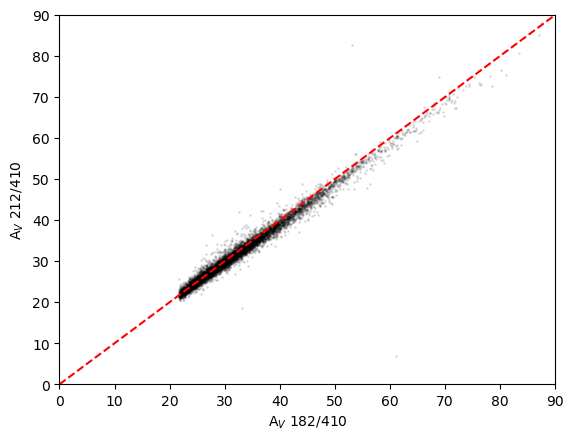

In [ ]:
ax = plt.subplot(111)
Av_182410 = cat_filament.get_Av_182410()
Av_212410 = cat_filament.get_Av_212410()

ax.scatter(Av_182410, Av_212410, s=1, alpha=0.1, color='k')
ax.plot([0, 90], [0, 90], 'r--')
ax.set_xlim(0, 90)
ax.set_ylim(0, 90)
ax.set_xlabel('A$_V$ 182/410')
ax.set_ylabel('A$_V$ 212/410')

<Axes: xlabel='F410M - F466N', ylabel='F410M'>

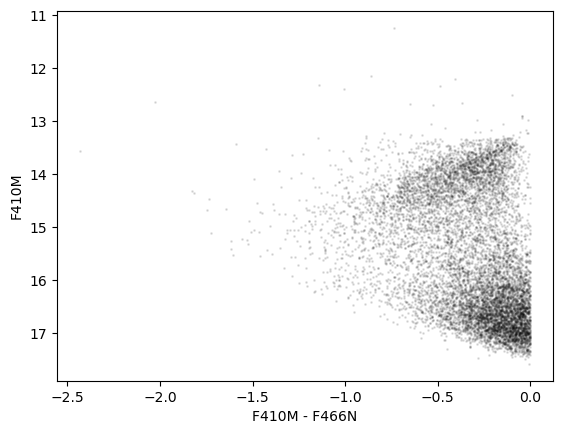

In [ ]:
cat_filament.plot_CMD('f410m', 'f466n', 'f410m', color='k', s=1, alpha=0.1, label='Filament')

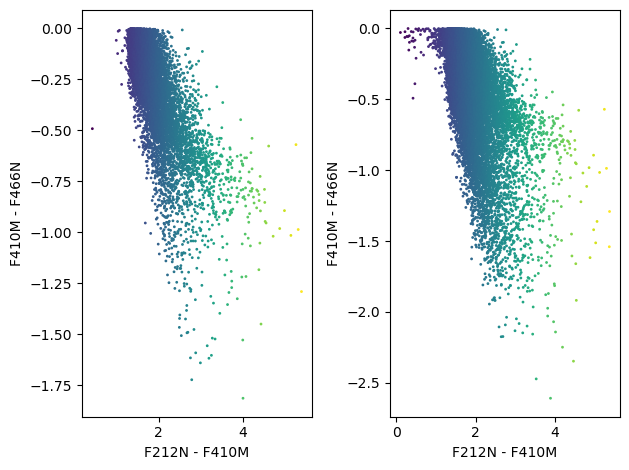

In [ ]:
ax = plt.subplot(121)
cat_filament.plot_CCD('f212n', 'f410m', 'f410m', 'f466n', c=cat_filament.color('f212n', 'f410m'), s=1, alpha=1, label='Filament', ax=ax)

ax1 = plt.subplot(122)
cat_use_m.plot_CCD('f212n', 'f410m', 'f410m', 'f466n', c=cat_use_m.color('f212n', 'f410m'), s=1, alpha=1, label='Use', ax=ax1)

plt.tight_layout()

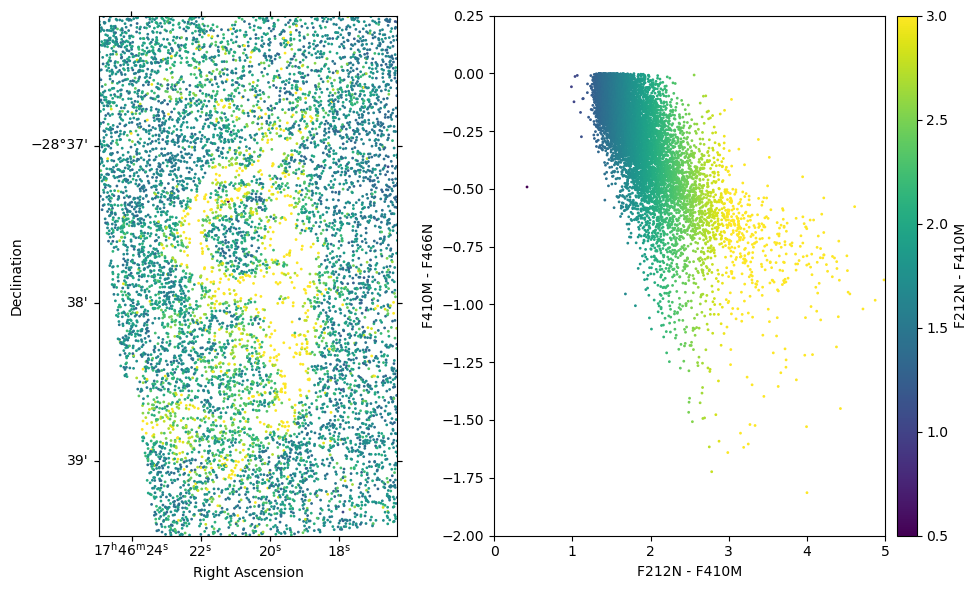

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(7*1.5,4*1.5))
ax1 = plt.subplot(121, projection=ww)
ax1.imshow(blank_cutout)
im = ax1.scatter(cat_filament.ra, cat_filament.dec, transform=ax1.get_transform('world'), s=1, c=cat_filament.color('f212n', 'f410m'), alpha=1, vmin=0.5, vmax=3)
ax1.set_xlabel('Right Ascension')
ax1.set_ylabel('Declination')

ax2 = plt.subplot(122)
cat_filament.plot_CCD('f212n', 'f410m', 'f410m', 'f466n', c=cat_filament.color('f212n', 'f410m'), s=1, alpha=1, ax=ax2, vmin=0.5, vmax=3)
ax2.set_xlim(0, 5)
ax2.set_ylim(-2, 0.25)

#plt.colorbar(im, ax=(ax1,ax2), label='F212N - F410M', use_gridspec=True)
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax, label='F212N - F410M')

plt.tight_layout()

plt.show()

Text(0, 0.5, 'F410M - F466N')

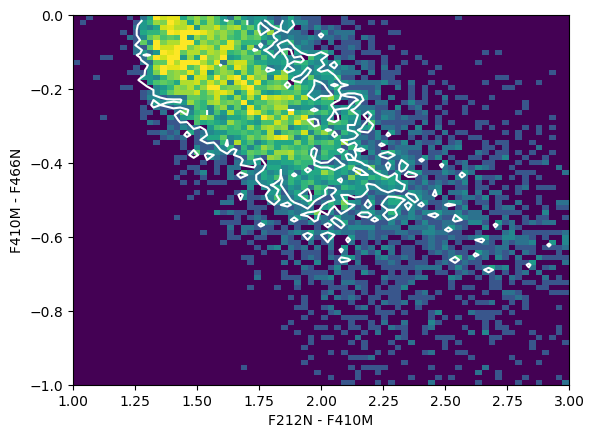

In [ ]:
#ax2 = plt.subplot(122)
#cat_filament.plot_CCD('f212n', 'f410m', 'f410m', 'f466n', c=cat_filament.color('f212n', 'f410m'), s=1, alpha=1, ax=ax2, vmin=0.5, vmax=3)
#ax2.set_xlim(0, 5)
#ax2.set_ylim(-2, 0.25)

binsx = np.linspace(1, 3, 75)
binsy = np.linspace(-1, 0., 75)
H, xedges, yedges = np.histogram2d(cat_filament.color('f212n', 'f410m'), cat_filament.color('f410m', 'f466n'), bins=(binsx, binsy))

plt.figure()
ax = plt.subplot(111)
norm = simple_norm(H, 'sqrt', percent=99)
ax.pcolormesh(xedges, yedges, H.T, cmap='viridis', norm=norm)
ax.contour(xedges[:-1], yedges[:-1], H.T, levels=[3], colors='w')
ax.set_xlabel('F212N - F410M')
ax.set_ylabel('F410M - F466N')

Text(0, 0.5, 'F410M - F466N')

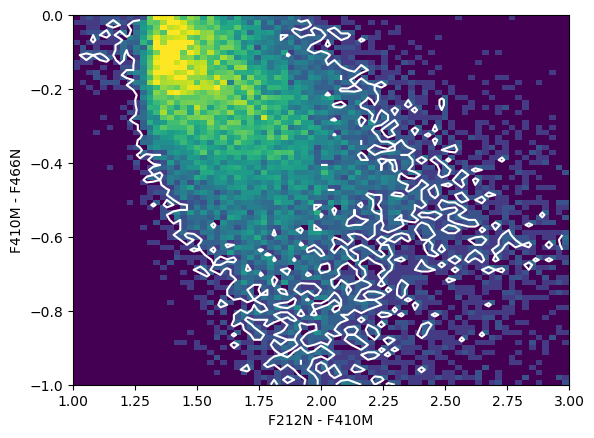

In [ ]:
binsx = np.linspace(1, 3, 75)
binsy = np.linspace(-1, 0., 75)
H, xedges, yedges = np.histogram2d(cat_use_m.color('f212n', 'f410m'), cat_use_m.color('f410m', 'f466n'), bins=(binsx, binsy))

plt.figure()
ax = plt.subplot(111)
norm = simple_norm(H, stretch='sqrt', percent=99)
ax.pcolormesh(xedges, yedges, H.T, cmap='viridis', norm=norm)
ax.contour(xedges[:-1], yedges[:-1], H.T, levels=[2], colors='w')
ax.set_xlabel('F212N - F410M')
ax.set_ylabel('F410M - F466N')

In [18]:
# Estimate Av using F212N - F410M / ext(F212N - F410M)
Av_212410 = cat_filament.get_Av_212410()

# CO

In [19]:
import icemodels
imp.reload(icemodels)
from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, load_molecule_ocdb, atmo_model, molecule_data
from icemodels.gaussian_model_components import co_ice_wls_icm, co_ice_wls, co_ice_widths, co_ice_bandstrength
co_ice_wls, co_ice_widths
from astroquery.svo_fps import SvoFps
from astropy import table

In [20]:

filter_data = SvoFps.get_filter_list('JWST', instrument="NIRCam")
filter_data.add_index('filterID')
flxd = filter_data['filterID']
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

In [21]:
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)

aspec = absorbed_spectrum(1e18*u.cm**-2, load_molecule('co'), spectrum=phx4000['fnu'], xarr=xarr)
trans = SvoFps.get_transmission_data(filterid)


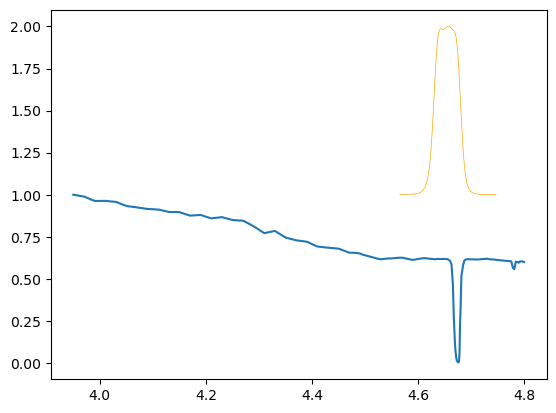

In [22]:
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)

aspec = absorbed_spectrum(1e18*u.cm**-2, load_molecule('co'), spectrum=phx4000['fnu'], xarr=xarr)
plt.plot(xarr.to(u.um), aspec / aspec.max())

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=0.5,
        color='orange')

In [ ]:
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)

aspec = absorbed_spectrum(1e18*u.cm**-2, load_molecule_ocdb('co'), spectrum=phx4000['fnu'], xarr=xarr)
plt.plot(xarr.to(u.um), aspec / aspec.max())

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=0.5,
        color='orange')

InconsistentTableError: Number of header columns (2) inconsistent with data columns in data line 1

In [23]:
# loading CO molecule
molecule = 'co'
# ocdb version gives nonsense
# CO molecule constants 
consts = load_molecule(molecule) # OCDB = optical constants database
# phx4000 = stellar atmosphere model spectrum at 4000K
xarr = phx4000['nu'].quantity.to(u.um, u.spectral())
# column densities of CO ice
cols = np.geomspace(1e15, 1e22, 25)
dmags410 = []
dmags466 = []

print(f"  column,   mag410,  mag410*,  mag466n, mag466n*, dmag410, dmag466")
for col in cols:
    # for each column density of CO (ice?), make a spectrum of it 
    # absorbed_spectrum takes spectrum and puts the effects of an absorption feature in front of it 
    spec = absorbed_spectrum(col*u.cm**-2, consts, molecular_weight=molecule_data[molecule]['molwt'],
                              spectrum=phx4000['fnu'].quantity, # flux array
                              xarr=xarr, # wavelength array
                             )
    cmd_x = ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')
    flxd_ref = fluxes_in_filters(xarr, phx4000['fnu'].quantity)
    flxd = fluxes_in_filters(xarr, spec)
    # the star's magnitude
    mags_x_star = (-2.5*np.log10(flxd_ref[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                   -2.5*np.log10(flxd_ref[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
    # the magnitude of the star with the CO ice
    #mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
    mags_x = (-2.5*np.log10(flxd[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
              -2.5*np.log10(flxd[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
    # the difference in magnitudes in F410M and F466N
    dmags466.append(mags_x[1]-mags_x_star[1])
    dmags410.append(mags_x[0]-mags_x_star[0])
    # why would f410m change at all?
    print(f"{col:8.1g}, {mags_x[0]:8.1f}, {mags_x_star[0]:8.1f}, {mags_x[1]:8.1f}, {mags_x_star[1]:8.1f}, {dmags410[-1]:8.1f}, {dmags466[-1]:8.1f}")

  column,   mag410,  mag410*,  mag466n, mag466n*, dmag410, dmag466
   1e+15,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   2e+15,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   4e+15,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   7e+15,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   1e+16,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   3e+16,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   6e+16,    -14.1,    -14.1,    -14.0,    -14.0,      0.0,      0.0
   1e+17,    -14.1,    -14.1,    -13.9,    -14.0,      0.0,      0.0
   2e+17,    -14.1,    -14.1,    -13.9,    -14.0,      0.0,      0.1
   4e+17,    -14.1,    -14.1,    -13.9,    -14.0,      0.0,      0.1
   8e+17,    -14.1,    -14.1,    -13.8,    -14.0,      0.0,      0.2
   2e+18,    -14.1,    -14.1,    -13.7,    -14.0,      0.0,      0.3
   3e+18,    -14.1,    -14.1,    -13.7,    -14.0,      0.0,      0.3
   6e+18,    -14.1,    -14.1,    -13

## Plot N(CO) as a function of F466N-F410M

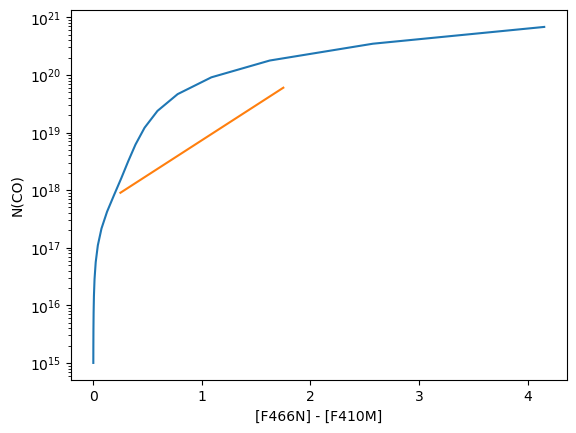

In [24]:
dmag_466m410 = np.array(dmags466) - np.array(dmags410) 
plt.semilogy(dmag_466m410[cols<1e21], cols[cols<1e21])
plt.xlabel('[F466N] - [F410M]')
plt.ylabel('N(CO)')
plt.plot([0.25, 1.75], [9e17, 6e19]);

In [34]:
slope = (np.log10(6e19) - np.log10(9e17)) / (1.75-0.25)
nco_uncert = slope * 0.1*np.sqrt(2)
slope, nco_uncert, 10**nco_uncert, 0.1*np.sqrt(2)

(1.2159391606295458,
 0.17195976519828612,
 1.4857979855607997,
 0.14142135623730953)

In [35]:
ext = CT06_MWLoc()
ext(4.66*u.um) - ext(4.1*u.um)

-0.004543222258976243

In [36]:
av212410 = cat_filament.color('f212n', 'f410m') / (CT06_MWLoc()(2.12*u.um) - CT06_MWLoc()(4.1*u.um))
av182212 = cat_filament.color('f182m', 'f212n') / (CT06_MWLoc()(1.82*u.um) - CT06_MWLoc()(2.12*u.um))
av182410 = cat_filament.color('f182m', 'f410m') / (CT06_MWLoc()(1.82*u.um) - CT06_MWLoc()(4.1*u.um))
av187405 = cat_filament.color('f187n', 'f405n') / (CT06_MWLoc()(1.87*u.um) - CT06_MWLoc()(4.05*u.um))

In [37]:
# F466N - F410M
measured_466m410 = cat_filament.color('f466n', 'f410m')

In [41]:
# F466N-F410M + (difference in the extinction law for F410M-F466N) * Av = unextincted, dereddened color, accounting for dust before CO
# should have the effect of increasing the CO column density
# using the og data, we would have a lower CO column density than we should
# when F466N - F410M is more positive
### Check the math here, write it out and be able to explain it to someone
### See if Adam's math is right 
unextincted_466m410_av212410 = measured_466m410 + (CT06_MWGC()(4.66*u.um) - CT06_MWGC()(4.10*u.um)) * av212410
inferred_co_column_av212410 = np.interp(unextincted_466m410_av212410, dmag_466m410[cols<1e21], cols[cols<1e21])

unextincted_466m410_av182212 = measured_466m410 + (CT06_MWGC()(4.66*u.um) - CT06_MWGC()(4.10*u.um)) * av182212
inferred_co_column_av182212 = np.interp(unextincted_466m410_av182212, dmag_466m410[cols<1e21], cols[cols<1e21])

unextincted_466m410_av182410 = measured_466m410 + (CT06_MWGC()(4.66*u.um) - CT06_MWGC()(4.10*u.um)) * av182410
inferred_co_column_av182410 = np.interp(unextincted_466m410_av182410, dmag_466m410[cols<1e21], cols[cols<1e21])

unextincted_466m410_av187405 = measured_466m410 + (CT06_MWGC()(4.66*u.um) - CT06_MWGC()(4.10*u.um)) * av187405
inferred_co_column_av187405 = np.interp(unextincted_466m410_av187405, dmag_466m410[cols<1e21], cols[cols<1e21])

cat_co = cat_filament.catalog.copy()
cat_co['N(CO)'] = inferred_co_column_av212410

In [39]:
(CT06_MWGC()(4.10*u.um) - CT06_MWGC()(4.66*u.um))

0.004543222258976243

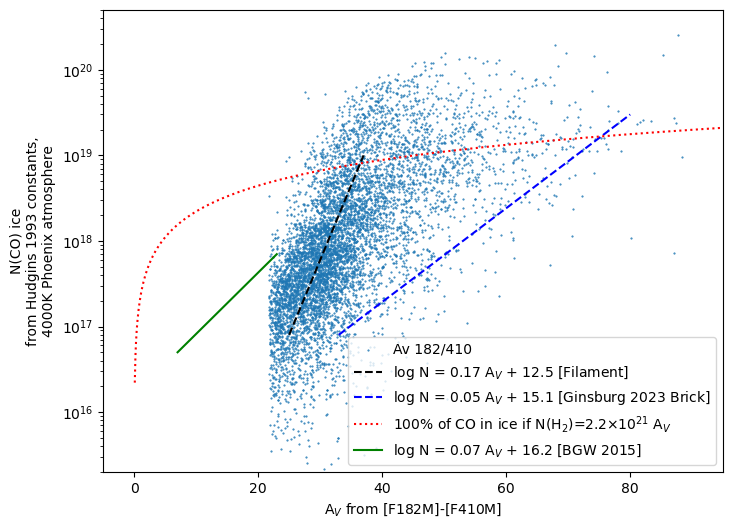

In [40]:
fig = plt.figure(figsize=(8,6))
plt.scatter(av182410, inferred_co_column_av182410, marker='.', label='Av 182/410', s=1)

NCOofAV = 2.21e21 * np.linspace(0.1, 100, 1000) * 1e-4
plt.xlim(-5, 95)
plt.ylim(2e15, 5e20)
#pl.plot([10, 35], [1e17, 1e20], 'k--', label='log N = 0.12 A$_V$ + 15.8');

# by eye fit Filament
x1,y1 = 25,8e16
x2,y2 = 37,1e19
m = (np.log10(y2) - np.log10(y1)) / (x2 - x1)
b = np.log10(y1 / 10**(m * x1))
plt.plot([x1, x2], 10**np.array([x1*m+b, x2*m+b]), 'k--', label=f'log N = {m:0.2f} A$_V$ + {b:0.1f} [Filament]')

# by-eye fit Brick
x1,y1 = 10,2e17
x2,y2 = 43,1e19
x1,y1 = 33,8e16
x2,y2 = 80,3e19
m = (np.log10(y2) - np.log10(y1)) / (x2 - x1)
b = np.log10(y1 / 10**(m * x1))
plt.plot([x1, x2], 10**np.array([x1*m+b, x2*m+b]), 'b--', label=f'log N = {m:0.2f} A$_V$ + {b:0.1f} [Ginsburg 2023 Brick]')

plt.plot(np.linspace(0.1, 100, 1000), NCOofAV,
        label='100% of CO in ice if N(H$_2$)=2.2$\\times10^{21}$ A$_V$', color='r', linestyle=':')
plt.plot([7, 23], [0.5e17, 7e17], 'g', label='log N = 0.07 A$_V$ + 16.2 [BGW 2015]')
plt.xlabel("A$_V$ from [F182M]-[F410M]")
plt.ylabel("N(CO) ice\nfrom Hudgins 1993 constants,\n4000K Phoenix atmosphere")
plt.yscale('log')
plt.legend()
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/filament_Av_vs_NCO_182410.pdf', bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/filament_Av_vs_NCO_182410.png', bbox_inches='tight', dpi=300)

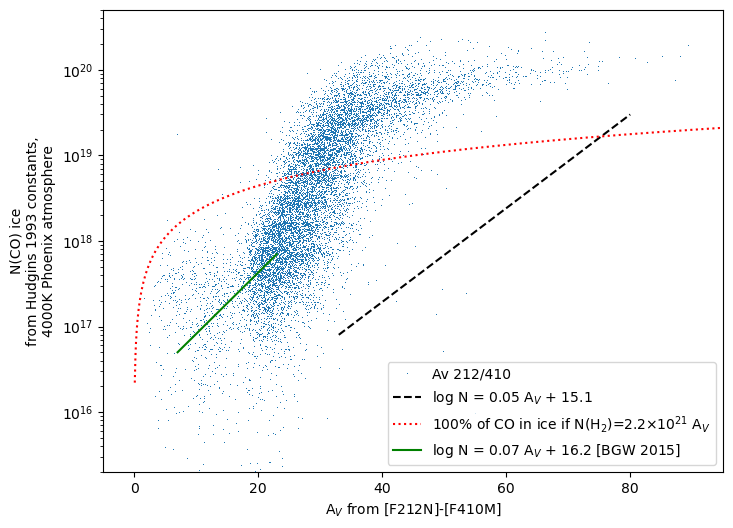

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.semilogy(av212410, inferred_co_column_av212410, marker=',', linestyle='none', label='Av 212/410')

NCOofAV = 2.21e21 * np.linspace(0.1, 100, 1000) * 1e-4
plt.xlim(-5, 95)
plt.ylim(2e15, 5e20)
#pl.plot([10, 35], [1e17, 1e20], 'k--', label='log N = 0.12 A$_V$ + 15.8');
# by-eye fit
x1,y1 = 10,2e17
x2,y2 = 43,1e19
x1,y1 = 33,8e16
x2,y2 = 80,3e19
m = (np.log10(y2) - np.log10(y1)) / (x2 - x1)
b = np.log10(y1 / 10**(m * x1))
plt.plot([x1, x2], 10**np.array([x1*m+b, x2*m+b]), 'k--', label=f'log N = {m:0.2f} A$_V$ + {b:0.1f}')
plt.plot(np.linspace(0.1, 100, 1000), NCOofAV,
        label='100% of CO in ice if N(H$_2$)=2.2$\\times10^{21}$ A$_V$', color='r', linestyle=':')
plt.plot([7, 23], [0.5e17, 7e17], 'g', label='log N = 0.07 A$_V$ + 16.2 [BGW 2015]')
plt.xlabel("A$_V$ from [F212N]-[F410M]")
plt.ylabel("N(CO) ice\nfrom Hudgins 1993 constants,\n4000K Phoenix atmosphere")
plt.legend()

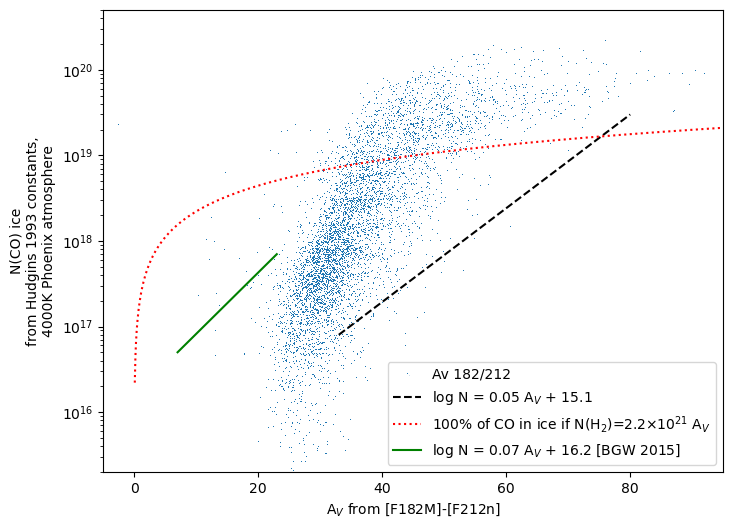

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.semilogy(av182212, inferred_co_column_av182212, marker=',', linestyle='none', label='Av 182/212')

NCOofAV = 2.21e21 * np.linspace(0.1, 100, 1000) * 1e-4
plt.xlim(-5, 95)
plt.ylim(2e15, 5e20)
#pl.plot([10, 35], [1e17, 1e20], 'k--', label='log N = 0.12 A$_V$ + 15.8');
# by-eye fit
x1,y1 = 10,2e17
x2,y2 = 43,1e19
x1,y1 = 33,8e16
x2,y2 = 80,3e19
m = (np.log10(y2) - np.log10(y1)) / (x2 - x1)
b = np.log10(y1 / 10**(m * x1))
plt.plot([x1, x2], 10**np.array([x1*m+b, x2*m+b]), 'k--', label=f'log N = {m:0.2f} A$_V$ + {b:0.1f}')
plt.plot(np.linspace(0.1, 100, 1000), NCOofAV,
        label='100% of CO in ice if N(H$_2$)=2.2$\\times10^{21}$ A$_V$', color='r', linestyle=':')
plt.plot([7, 23], [0.5e17, 7e17], 'g', label='log N = 0.07 A$_V$ + 16.2 [BGW 2015]')
plt.xlabel("A$_V$ from [F182M]-[F212n]")
plt.ylabel("N(CO) ice\nfrom Hudgins 1993 constants,\n4000K Phoenix atmosphere")
plt.legend()

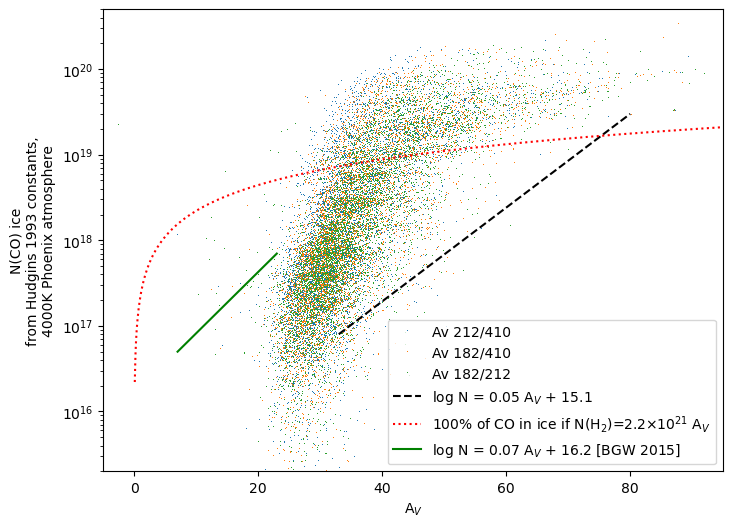

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.semilogy(av212410, inferred_co_column_av212410, marker=',', linestyle='none', label='Av 212/410')
plt.semilogy(av182410, inferred_co_column_av182410, marker=',', linestyle='none', label='Av 182/410')
plt.semilogy(av182212, inferred_co_column_av182212, marker=',', linestyle='none', label='Av 182/212')

NCOofAV = 2.21e21 * np.linspace(0.1, 100, 1000) * 1e-4
plt.xlim(-5, 95)
plt.ylim(2e15, 5e20)
#pl.plot([10, 35], [1e17, 1e20], 'k--', label='log N = 0.12 A$_V$ + 15.8');
# by-eye fit
x1,y1 = 10,2e17
x2,y2 = 43,1e19
x1,y1 = 33,8e16
x2,y2 = 80,3e19
m = (np.log10(y2) - np.log10(y1)) / (x2 - x1)
b = np.log10(y1 / 10**(m * x1))
plt.plot([x1, x2], 10**np.array([x1*m+b, x2*m+b]), 'k--', label=f'log N = {m:0.2f} A$_V$ + {b:0.1f}')
plt.plot(np.linspace(0.1, 100, 1000), NCOofAV,
        label='100% of CO in ice if N(H$_2$)=2.2$\\times10^{21}$ A$_V$', color='r', linestyle=':')
plt.plot([7, 23], [0.5e17, 7e17], 'g', label='log N = 0.07 A$_V$ + 16.2 [BGW 2015]')
plt.xlabel("A$_V$")
plt.ylabel("N(CO) ice\nfrom Hudgins 1993 constants,\n4000K Phoenix atmosphere")
plt.legend()

# N(CO) Map

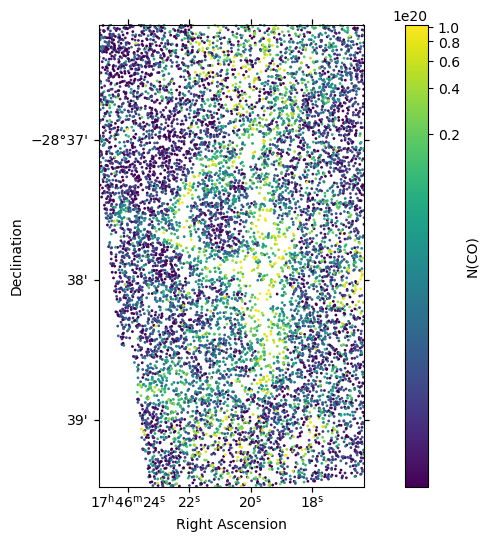

In [ ]:
fig = plt.figure(figsize=(7*1.5,4*1.5))
ax1 = plt.subplot(111, projection=ww)
ax1.imshow(blank_cutout)
norm = simple_norm(cat_co['N(CO)'], 'log', percent=99)
im = ax1.scatter(cat_filament.ra, cat_filament.dec, transform=ax1.get_transform('world'), s=1, c=cat_co['N(CO)'], alpha=1, norm=norm)
ax1.set_xlabel('Right Ascension')
ax1.set_ylabel('Declination')
plt.colorbar(im, label='N(CO)')

In [49]:
cat = JWSTCatalog(cat_use.table_region_mask([reg], ww))
mask = (cat.color('f182m', 'f410m') > 2) | (np.isnan(np.array(cat.band('f182m'))) & ~np.isnan(np.array(cat.band('f410m'))))
mask = mask & (cat.color('f410m', 'f466n') < 0)
cat = JWSTCatalog(cat.catalog[mask])

In [50]:
cat.catalog['N(CO)'] = np.interp(cat.color('f466n', 'f410m'), dmag_466m410[cols<1e21], cols[cols<1e21])

In [51]:
cutout_405 = cm.get_cutout_405(pos, w, l)
grid = ex.make_grid(cutout_405.data.shape)
ww = cutout_405.wcs
pixel_scale = ww.proj_plane_pixel_scales()[0] * u.deg.to(u.arcsec)

k = 1
data = ex.get_pixcoords(cat, ww)
seps, inds = ex.make_kdtree(data, k=k)
grid = ex.fill_grid(grid, data, cat.catalog['N(CO)'])

In [56]:
grid_interp = ex.interpolate_grid(grid, 30)

In [70]:
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5*u.kpc).to(u.cm, u.dimensionless_angles())**2
mpp = 2.8*u.Da
(np.nansum(grid_interp) * u.cm**(-2) * pixel_area_physical * mpp * 100).to(u.Msun)

<Quantity 363.81074289 solMass>

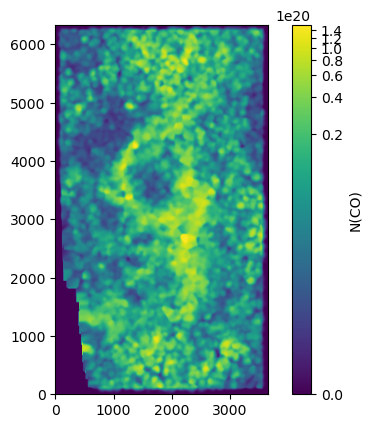

In [61]:
norm = simple_norm(grid_interp, 'log', percent=99.9)
im = plt.imshow(grid_interp, norm=norm, origin='lower')
plt.colorbar(im, label='N(CO)')

# Old

In [ ]:
print(

## CO Files

In [ ]:
fn_12CO = '/orange/adamginsburg/cmz/nobeyama/12CO-2.BEARS.FITS'
fn_13CO = '/orange/adamginsburg/cmz/nobeyama/13CO-2.FOREST.FITS'
fn_C18O = '/orange/adamginsburg/cmz/nobeyama/C18O-2.FOREST.FITS'

In [ ]:
cube_12CO = SpectralCube.read(fn_12CO, format='fits')
cube_13CO = SpectralCube.read(fn_13CO, format='fits')
cube_C18O = SpectralCube.read(fn_C18O, format='fits')

In [ ]:
subcube_12CO = cube_12CO.spectral_slab(-56*u.km/u.s, -54*u.km/u.s)
subcube_13CO = cube_13CO.spectral_slab(-56*u.km/u.s, -54*u.km/u.s)
subcube_C18O = cube_C18O.spectral_slab(-56*u.km/u.s, -54*u.km/u.s)

In [ ]:
reg = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/f4_fov_cloudc.reg')

In [ ]:
mom0_12CO = subcube_12CO.subcube_from_regions(reg).moment0()
mom0_13CO = subcube_13CO.subcube_from_regions(reg).moment0()
mom0_C18O = subcube_C18O.subcube_from_regions(reg).moment0()

## Catalog

In [ ]:
cat_use = make_cat_use()

In [ ]:
reg_filament = Regions.read(f'../regions_/filament_short.region')

cat_filament = JWSTCatalog(cat_use.table_region_mask(reg_filament, wcs=mom0_12CO.wcs))

In [ ]:
basetable = cat_filament.catalog

## Av

In [ ]:
from dust_extinction.averages import CT06_MWGC
av182410 = (basetable['mag_ab_f182m'] - basetable['mag_ab_f410m']) / (CT06_MWGC()(1.82*u.um) - CT06_MWGC()(4.10*u.um))
a182 = CT06_MWGC()(1.82*u.um)
f182mdr = basetable['mag_ab_f182m'] - a182 * av182410

## Select Region of CO Data

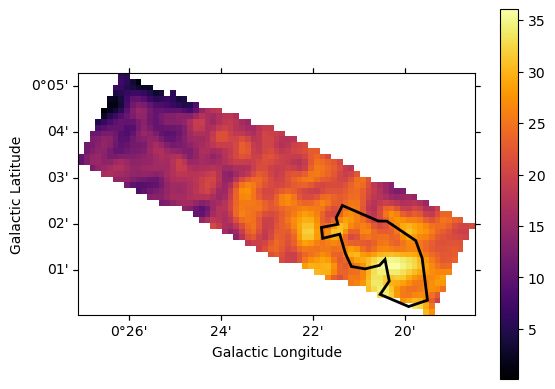

In [ ]:
ax = plt.subplot(projection=mom0_12CO.wcs)
im = ax.imshow(mom0_12CO.value, origin='lower', cmap='inferno', norm=simple_norm(mom0_12CO.value, stretch='linear', max_percent=99.9))
plt.colorbar(im)
#reg[0].to_pixel(mom0_12CO.wcs).plot(ax=ax, edgecolor='k')
reg_filament[0].to_pixel(mom0_12CO.wcs).plot(ax=ax, edgecolor='k')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

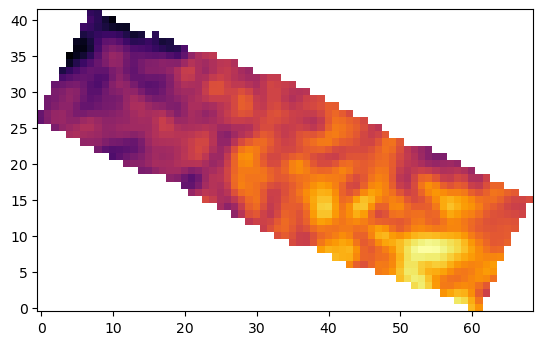

In [ ]:
#ax = plt.subplot(projection=mom0_12CO.wcs)
im = plt.imshow(mom0_12CO.value, origin='lower', cmap='inferno', norm=simple_norm(mom0_12CO.value, stretch='linear', max_percent=99.9))
#plt.colorbar(im)
#reg[0].to_pixel(mom0_12CO.wcs).plot(ax=ax, edgecolor='k')
#plt.xlabel('Galactic Longitude')
#plt.ylabel('Galactic Latitude')

In [ ]:
ww_12CO = mom0_12CO.wcs
crds_pix_12CO = np.array(ww_12CO.world_to_pixel(basetable['skycoord_ref']))

ww_13CO = mom0_13CO.wcs
crds_pix_13CO = np.array(ww_13CO.world_to_pixel(basetable['skycoord_ref']))

ww_C18O = mom0_C18O.wcs
crds_pix_C18O = np.array(ww_C18O.world_to_pixel(basetable['skycoord_ref']))

In [ ]:
tbl = basetable.copy()
#tbl['W_12CO'] = 
tbl['mom0_12CO'] = mom0_12CO.value[crds_pix_12CO[1].astype(int), crds_pix_12CO[0].astype(int)]
tbl['mom0_13CO'] = mom0_13CO.value[crds_pix_13CO[1].astype(int), crds_pix_13CO[0].astype(int)]
tbl['mom0_C18O'] = mom0_C18O.value[crds_pix_C18O[1].astype(int), crds_pix_C18O[0].astype(int)]
tbl['Av'] = av182410
tbl['182m410'] = tbl['mag_ab_f182m'] - tbl['mag_ab_f410m']
tbl['H2 cm-2'] = tbl['mom0_12CO']*2e20*u.cm**-2/(u.K*u.km/u.s)

Text(0, 0.5, '12CO Moment 0 (K km/s)')

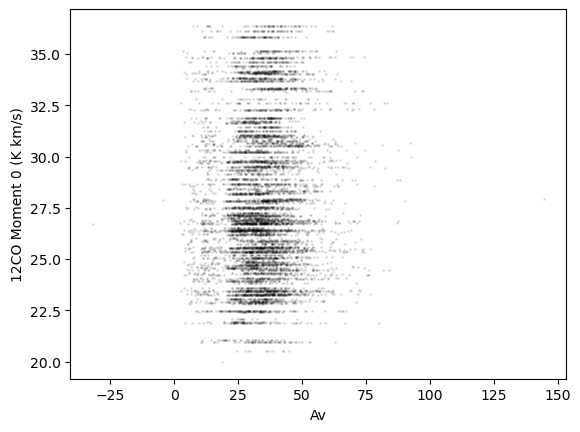

In [ ]:
plt.scatter(tbl['Av'], tbl['mom0_12CO'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('12CO Moment 0 (K km/s)')
#plt.xlim(0, 60)

Text(0, 0.5, '13CO Moment 0 (K km/s)')

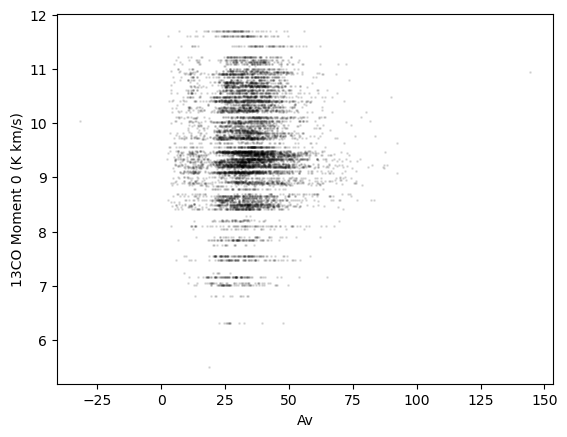

In [ ]:
plt.scatter(tbl['Av'], tbl['mom0_13CO'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('13CO Moment 0 (K km/s)')
#plt.xlim(0, 60)

Text(0, 0.5, 'C18O Moment 0 (K km/s)')

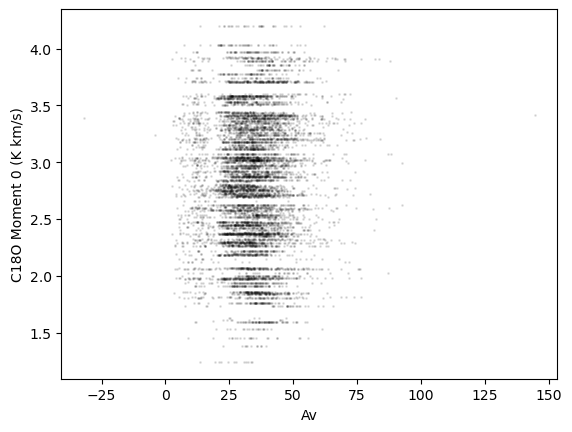

In [ ]:
plt.scatter(tbl['Av'], tbl['mom0_C18O'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('C18O Moment 0 (K km/s)')
#plt.xlim(0, 60)

Text(0, 0.5, 'H2 cm-2 (X_CO = 2e20 cm-2/(K km/s))')

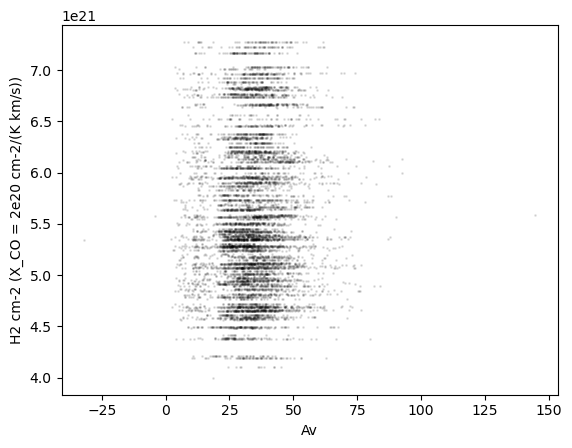

In [ ]:
plt.scatter(tbl['Av'], tbl['H2 cm-2'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('H2 cm-2 (X_CO = 2e20 cm-2/(K km/s))')
#plt.xlim(0, 60)

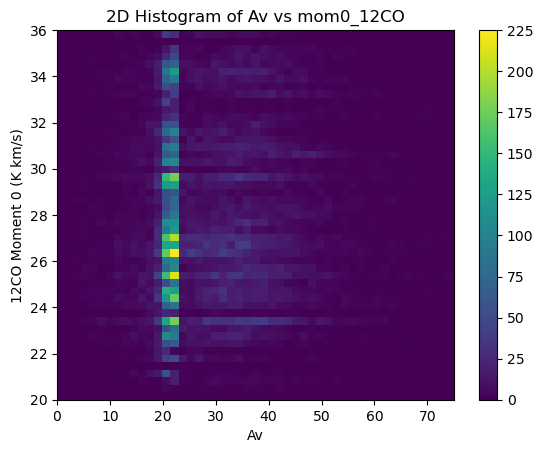

In [ ]:
xbins = np.linspace(0, 75, 50)
ybins = np.linspace(20, 36, 50)

h, xedges, yedges = np.histogram2d(tbl['Av'], tbl['mom0_12CO'], bins=[xbins, ybins])

plt.imshow(h.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', origin='lower')#, norm=simple_norm(h, stretch='log', max_percent=99.9))

plt.colorbar()
plt.xlabel('Av')
plt.ylabel('12CO Moment 0 (K km/s)')
plt.title('2D Histogram of Av vs mom0_12CO')
plt.show()